# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
from pandas.io.parsers import read_csv

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Load id -> signname mapping file
signnames = read_csv("signnames.csv").values[:, 1]

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape
train_shape = X_train.shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Train set shape =", train_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Train set shape = (39209, 32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

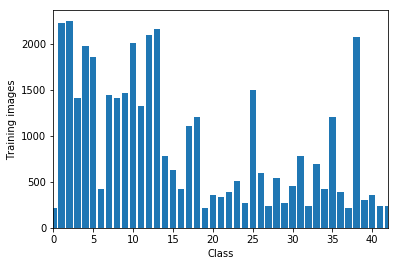

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Visualizations will be shown in the notebook.
%matplotlib inline

sign_classes, index_start_of_classes, class_counts = np.unique(y_train, return_index = True, return_counts = True)

plt.bar(np.arange(43), class_counts)
plt.xlabel('Class')
plt.ylabel('Training images')
plt.xlim([0, 42])

plt.savefig('examples/class_count.png', bbox_inches='tight')
plt.show()

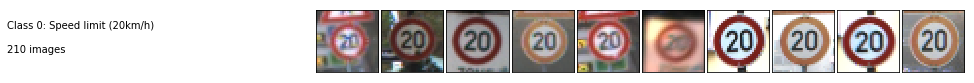

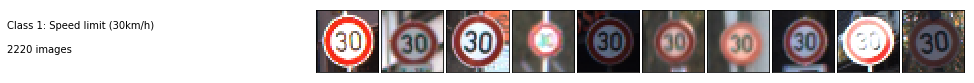

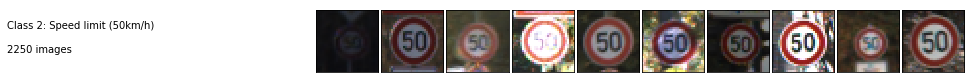

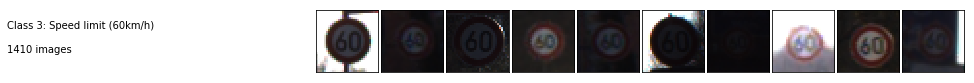

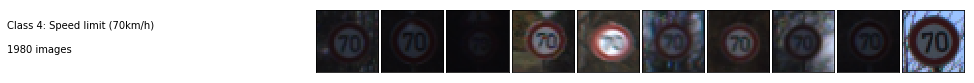

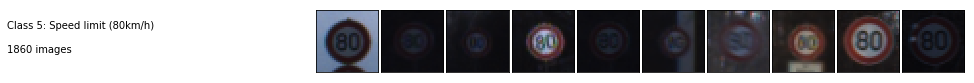

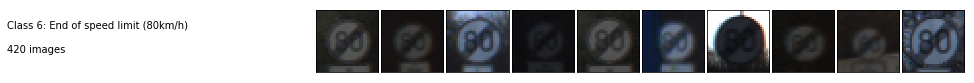

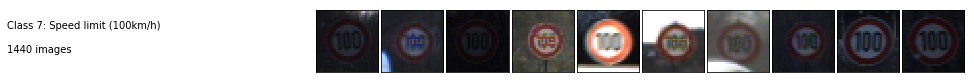

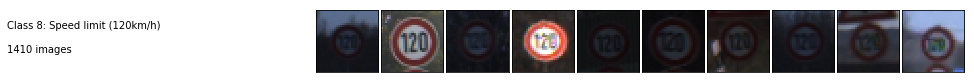

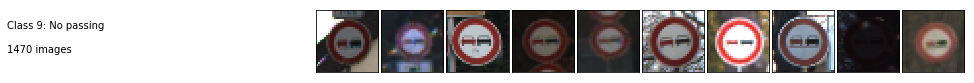

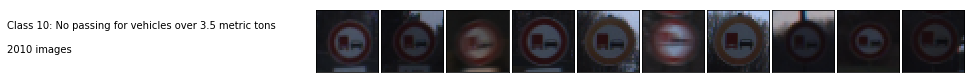

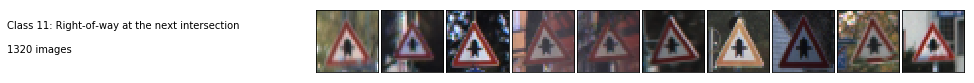

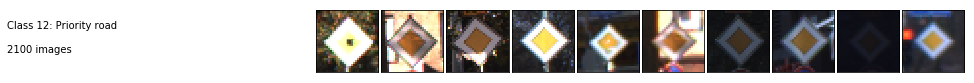

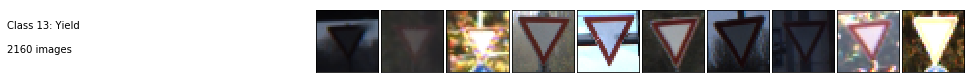

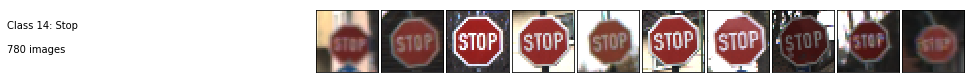

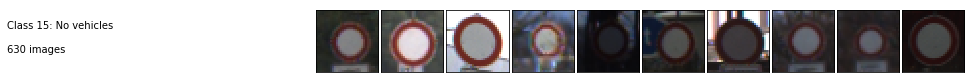

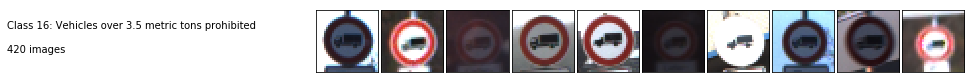

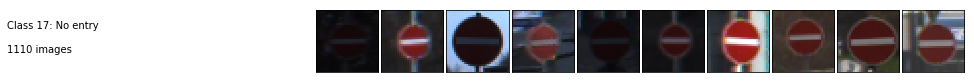

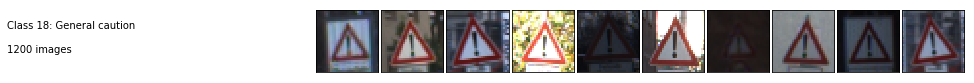

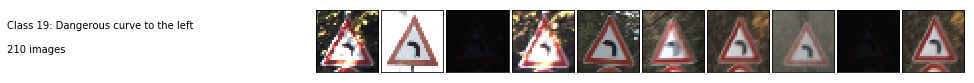

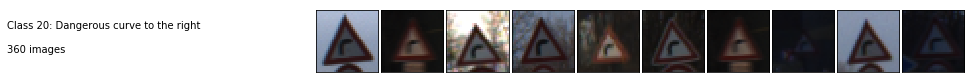

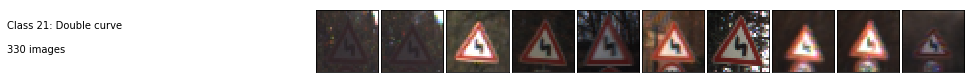

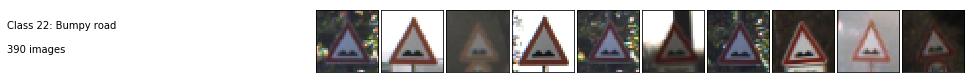

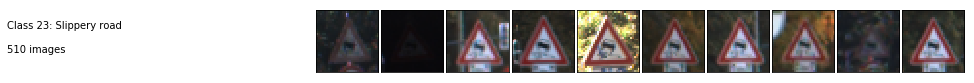

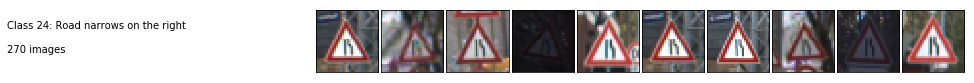

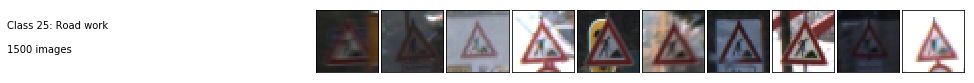

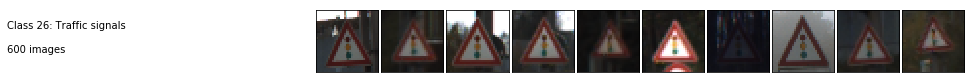

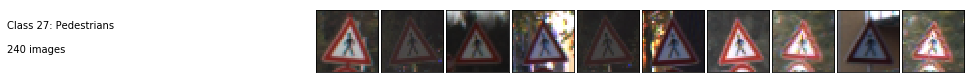

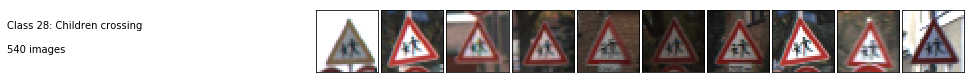

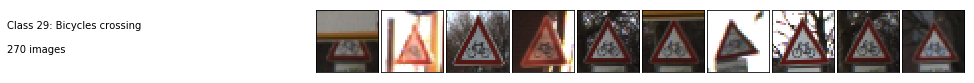

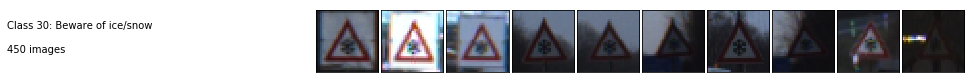

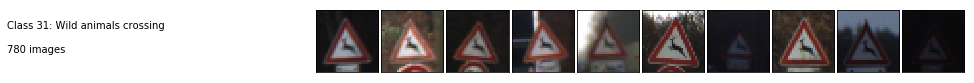

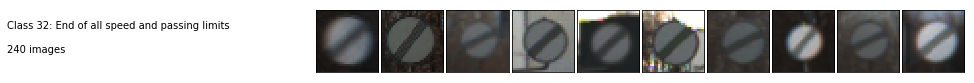

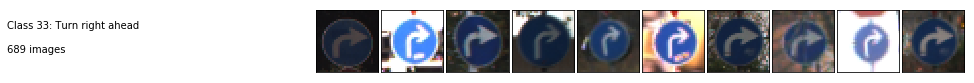

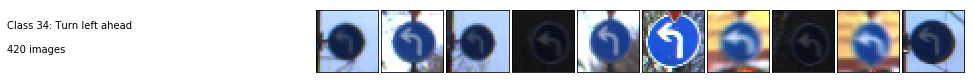

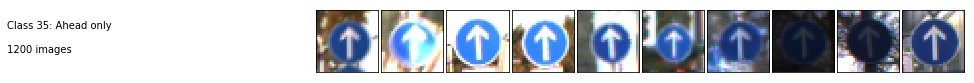

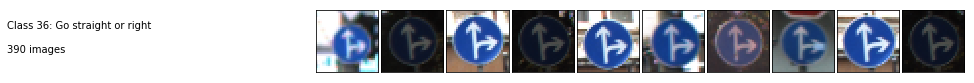

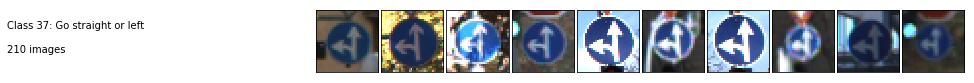

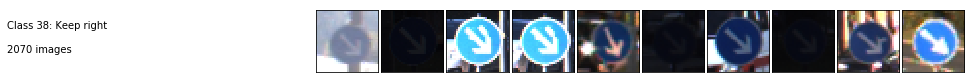

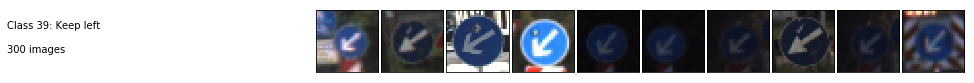

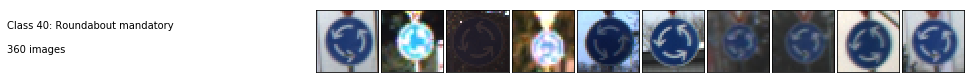

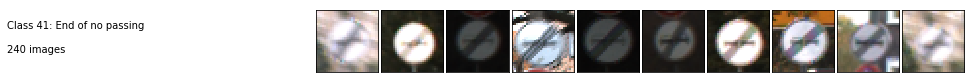

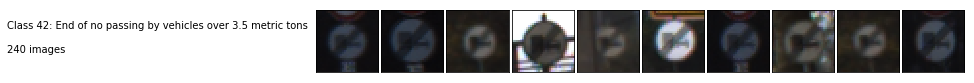

In [4]:
for sign_class, class_index_start, class_count in zip(sign_classes, index_start_of_classes, class_counts):
    fig = plt.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1.5, bottom = 0, top = 1.5, hspace = 0.05, wspace = 0.05)
    
    # Since the images is ordered by class, this line creates 10 random numbers in range (class_index_start , class_index_start + class_count)
    # to generate the indices for 10 random images. 
    random_indices = random.sample(range(class_index_start, class_index_start + class_count), 10)
    
    for i in range(10):
        axis = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
        if i == 0:
            axis.text(x = -160, y = 5, s = "Class %i: %s\n\n%s images" % (sign_class, signnames[sign_class], str(class_count)), rotation = 0, va = "top")
        axis.imshow(X_train[random_indices[i]])
        
    plt.show()

----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle
import os


def grayscale_image(img):
    # Took this function from P1 (Lane finder project)
    # It worked fine with the traffic-signs-data, but got an error:
    # "error: (-215) depth == CV_8U || depth == CV_16U || depth == CV_32F in function cv::cvtColor"
    # when using it with png images (bmp -> png) from internet.
    # Never found the solution.
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def _grayscale_dataset(X):
    # This method worked fine with the traffic-signs-data, but not with my custom images.
    """ Returns a new set with dimansion (?, 32, 32, 1)"""
    X_temp = np.empty([0, 32, 32, 1], dtype = np.int32)

    for i in range(X.shape[0]):
        gray = grayscale_image(X[i])
        gray = gray.reshape(gray.shape + (1,))
        X_temp = np.append(X_temp, [gray[:, :, :1]], axis = 0)

    return X_temp


def grayscale_dataset(X):
    # Found this on the internet. About 1000+ times faster than my first attempt to grayscale.
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    X = X.reshape(X.shape + (1,))
    
    return X
    
def normalize_dataset(X):
#     X = ((X-128) / 128.).astype(np.float32)
    X = (X / 255.).astype(np.float32) # Using this makes the images look much better, and leads to better results..

    return X

def preprocess_dataset(X):
    X = grayscale_dataset(X)
    X = normalize_dataset(X)
   
    return X
 
def read_pickle(file_path):
    if os.path.isfile(file_path):
        with open(file_path, "rb") as f:
            try:
                return pickle.load(f)
            except StandardError:
                pass
    
    return False

def acquire_preprocessed_data():
    path = 'preprocessed_traffic-signs-data/'
    preprocessed_data_file = path + 'preprocessed_features.p'
    
    preprocessed_data = read_pickle(preprocessed_data_file)
    if(preprocessed_data):
        print('File found and loaded')
    else:
        print('No file found. Preprocess started...')
        X_test_preprocessed = preprocess_dataset(X_test)
        X_train_preprocessed = preprocess_dataset(X_train)
        test_preprocessed = {"features":X_test_preprocessed, 'labels':y_test}
        train_preprocessed = {"features":X_train_preprocessed, 'labels':y_train}
        preprocessed_data = {'test':test_preprocessed, 'train':train_preprocessed}
        
        print('Creating new file.')
        with open(preprocessed_data_file, "wb") as f:
            pickle.dump(preprocessed_data, f)
   
    return preprocessed_data


preprocessed_data = acquire_preprocessed_data()
test_prep = preprocessed_data['test']
train_prep = preprocessed_data['train']
X_test_prep = test_prep['features']
X_train_prep = train_prep['features']
y_test_prep = test_prep['labels']
y_train_prep = train_prep['labels']

print('Preprocess complete.')

File found and loaded
Preprocess complete.


Lets have a look at the images before and after preprocess.

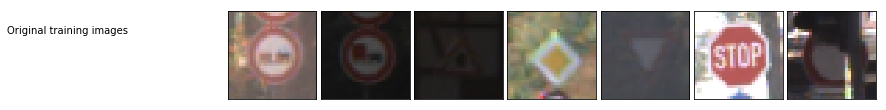

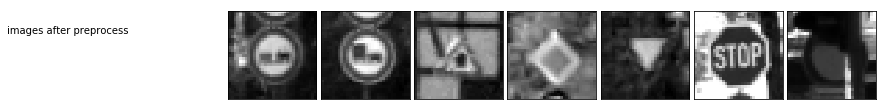

In [6]:
fig = plt.figure(figsize = (6, 1))
fig.subplots_adjust(left = 0, right = 1.5, bottom = 0, top = 1.5, hspace = 0.05, wspace = 0.05)

for i in range(7):
    axis = fig.add_subplot(1, 7, i+1, xticks=[], yticks=[])
    if i == 0:
        axis.text(x = -80, y = 5, s = "Original training images", rotation = 0, va = "top")
    axis.imshow(X_train[index_start_of_classes[i+9]])
    
plt.savefig('examples/orig_train_images.png', bbox_inches='tight')
fig = plt.figure(figsize = (6, 1))
fig.subplots_adjust(left = 0, right = 1.5, bottom = 0, top = 1.5, hspace = 0.05, wspace = 0.05)


for i in range(7):
    axis = fig.add_subplot(1, 7, i+1, xticks=[], yticks=[])
    if i == 0:
        axis.text(x = -80, y = 5, s = "images after preprocess", rotation = 0, va = "top")
    img = np.reshape(X_train_prep[index_start_of_classes[i+9]], (32,32))
    axis.imshow(img, cmap = plt.get_cmap('gray'))
plt.savefig('examples/prep_train_images.png', bbox_inches='tight')

plt.show()


### Split Data into Training, Validation and Testing Sets

In [7]:
from sklearn.model_selection import train_test_split

# The split is made randomly and renders the remaining train dataset shuffled.
X_train_prep, X_validation_prep, y_train_prep, y_validation_prep = train_test_split(X_train_prep, y_train_prep, test_size=0.20)

In [8]:
print(len(X_validation_prep))

7842


### Model Architecture

In [9]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

EPOCHS = 400
BATCH_SIZE = 128

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # (CNN layer) input: 32x32x1
    conv1_3x3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 16), mean = mu, stddev = sigma))
    conv1_3x3_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_3x3_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_3x3_b
    conv1 = tf.nn.relu(conv1)
    #output: 32x32x16
    
    # (CNN layer)
    conv2_3x3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 16), mean = mu, stddev = sigma))
    conv2_3x3_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_3x3_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_3x3_b
    conv2 = tf.nn.relu(conv2)
    #output: 32x32x16
    
    maxpool1 = tf.nn.max_pool( conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding='SAME')
    # output: 16x16x16
    
    # (CNN layer)
    conv3_3x3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 32), mean = mu, stddev = sigma))
    conv3_3x3_b = tf.Variable(tf.zeros(32))
    conv3   = tf.nn.conv2d(maxpool1, conv3_3x3_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_3x3_b
    conv3 = tf.nn.relu(conv3)
    #output: 16x16x32
    
    # (CNN layer)
    conv4_3x3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
    conv4_3x3_b = tf.Variable(tf.zeros(64))
    conv4   = tf.nn.conv2d(conv3, conv4_3x3_W, strides=[1, 1, 1, 1], padding='SAME') + conv4_3x3_b
    conv4 = tf.nn.relu(conv4)
    # output 16x16x64
    
    maxpool2 = tf.nn.max_pool( conv4, ksize = [1,2,2,1], strides = [1,2,2,1], padding='SAME')
    # output 8x8x64
    
#     print(maxpool2.get_shape())

    # flatten to prepare for multi-scale
    maxpool1_flat = flatten(maxpool1)
    maxpool2_flat = flatten(maxpool2)
    
    # multi-scale
    fc0   = tf.concat(1, [maxpool1_flat, maxpool2_flat])
#     print(fc0.get_shape())
    
    
    # (Fully Connected) Input = 432.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(8192, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    # Output = 120
    
    # Activation
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # (Fully Connected) Input = 120
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    # Output = 43.
    
    return logits



In [10]:
# features and labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32) 


# training pipeline
rate = 0.0001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
prediction = tf.argmax(logits,1)
softmax = tf.nn.softmax(logits)
top_5 = tf.nn.top_k(softmax, 5)

# store trained NN 
saver = tf.train.Saver()

def predict(X_data):
    sess = tf.get_default_session()
    predictions = sess.run(prediction, feed_dict={x: X_data, keep_prob: 1.0})
    return predictions

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def top_5_probs(x_data, y_data):
    sess = tf.get_default_session()
    
    probs = sess.run(top_5, feed_dict={x: x_data, keep_prob: 1.0})

    return probs
    

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_prep, y_train_prep = shuffle(X_train_prep, y_train_prep)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_prep[offset:end], y_train_prep[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.8})
            
        validation_accuracy = evaluate(X_validation_prep, y_validation_prep)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.193

EPOCH 2 ...
Validation Accuracy = 0.498

EPOCH 3 ...
Validation Accuracy = 0.698

EPOCH 4 ...
Validation Accuracy = 0.734

EPOCH 5 ...
Validation Accuracy = 0.858

EPOCH 6 ...
Validation Accuracy = 0.857

EPOCH 7 ...
Validation Accuracy = 0.887

EPOCH 8 ...
Validation Accuracy = 0.931

EPOCH 9 ...
Validation Accuracy = 0.948

EPOCH 10 ...
Validation Accuracy = 0.790

EPOCH 11 ...
Validation Accuracy = 0.952

EPOCH 12 ...
Validation Accuracy = 0.935

EPOCH 13 ...
Validation Accuracy = 0.944

EPOCH 14 ...
Validation Accuracy = 0.960

EPOCH 15 ...
Validation Accuracy = 0.962

EPOCH 16 ...
Validation Accuracy = 0.977

EPOCH 17 ...
Validation Accuracy = 0.973

EPOCH 18 ...
Validation Accuracy = 0.776

EPOCH 19 ...
Validation Accuracy = 0.979

EPOCH 20 ...
Validation Accuracy = 0.978

EPOCH 21 ...
Validation Accuracy = 0.977

EPOCH 22 ...
Validation Accuracy = 0.979

EPOCH 23 ...
Validation Accuracy = 0.973

EPOCH 24 ...
Validation Accura

In [12]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_prep, y_test_prep)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.959


---

## Step 3: Test a Model on New Images

### Load and Output the Images

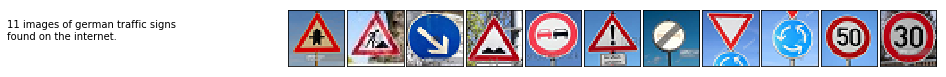

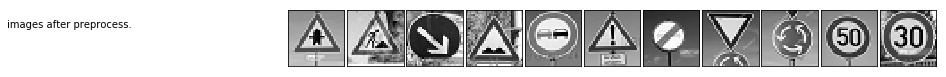

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


# labels for 11 custom images
y_c = np.array([11,25,38,22,9,18,32,13,40,2,1])

# empty numpy-array with correct dimansion (32x32x3)
X_c = np.empty([0, 32, 32, 3], dtype = np.int32)

# loop throu images and append to numpy-array
for i in range(11):
    img_file = 'images/' + str(i+1) +'.png'
    img_arr = mpimg.imread(img_file)
    
    X_c = np.append(X_c, [img_arr[:,:,:3]], axis=0)
    
# preprocess custom images    
X_c_prep = grayscale_dataset(X_c)

fig = plt.figure(figsize = (6, 1))
fig.subplots_adjust(left = 0, right = 1.5, bottom = 0, top = 1.5, hspace = 0.05, wspace = 0.05)
    
for i in range(11):
    axis = fig.add_subplot(1, 11, i+1, xticks=[], yticks=[])
    if i == 0:
        axis.text(x = -160, y = 5, s = "11 images of german traffic signs\nfound on the internet.", rotation = 0, va = "top")
    
    axis.imshow(X_c[i])

plt.show()

fig = plt.figure(figsize = (6, 1))
fig.subplots_adjust(left = 0, right = 1.5, bottom = 0, top = 1.5, hspace = 0.05, wspace = 0.05)
    
for i in range(11):
    axis = fig.add_subplot(1, 11, i+1, xticks=[], yticks=[])
    if i == 0:
        axis.text(x = -160, y = 5, s = "images after preprocess.", rotation = 0, va = "top")
    
    # Image with shape (32x32x1) does not work with imshow(). Reshaping to (32x32).
    img = np.reshape(X_c_prep[i], (32,32))
    axis.imshow(img, cmap = plt.get_cmap('gray'))

plt.show()

### Predict the Sign Type for Each Image

In [14]:
# The custom images have been converted from bmp to png and in that process the images was normalized.
# I did not get around this (which are a little embarrasing).
# Solved it by only going for grayscale on the custom images,
# which means they have not passed the same pipeline as the traffic-signs-data images.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    predictions = predict(X_c_prep)

Show signs and their predictions.

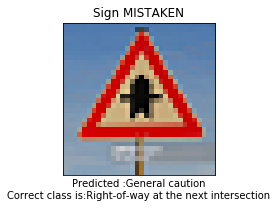

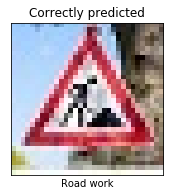

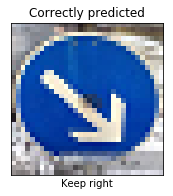

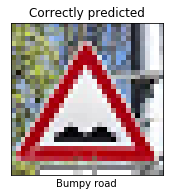

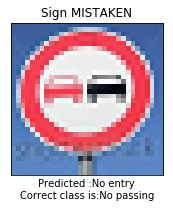

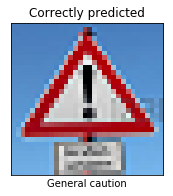

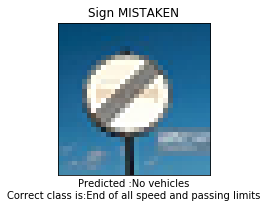

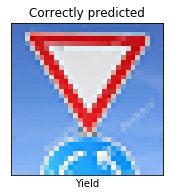

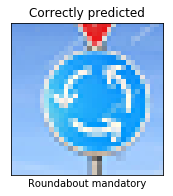

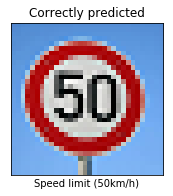

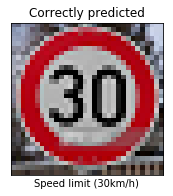

In [15]:
for prediction, image, correct_class in zip(predictions, X_c, y_c):
    fig = plt.figure()
    axis = fig.add_subplot(1, 2, 1+1, xticks=[], yticks=[])
    
    if prediction == correct_class:
        axis.set_title('Correctly predicted') # %s' % signnames[prediction])
        axis.set_xlabel(signnames[prediction])
    else:
        axis.set_title('Sign MISTAKEN')
        axis.set_xlabel('Predicted :%s\nCorrect class is:%s' % (signnames[prediction], signnames[correct_class]))
        
    plt.imshow(image)
    plt.show()


### Analyze Performance

Calculating the accuracy for these 11 new images just like when accuracy was measured for the validation and test sets.

100 % accuracy sounds good, but the pictures was clean and without noise.

In [16]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_c_prep, y_c)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.727


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

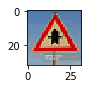

1.00 percent probabilty of :General caution
0.00 percent probabilty of :Right-of-way at the next intersection
0.00 percent probabilty of :Wild animals crossing
0.00 percent probabilty of :Speed limit (80km/h)
0.00 percent probabilty of :Bicycles crossing
--------------------------


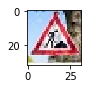

1.00 percent probabilty of :Road work
0.00 percent probabilty of :Double curve
0.00 percent probabilty of :Bicycles crossing
0.00 percent probabilty of :Traffic signals
0.00 percent probabilty of :Speed limit (80km/h)
--------------------------


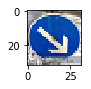

1.00 percent probabilty of :Keep right
0.00 percent probabilty of :Speed limit (50km/h)
0.00 percent probabilty of :Speed limit (30km/h)
0.00 percent probabilty of :Speed limit (20km/h)
0.00 percent probabilty of :Double curve
--------------------------


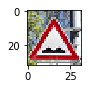

1.00 percent probabilty of :Bumpy road
0.00 percent probabilty of :Road work
0.00 percent probabilty of :Road narrows on the right
0.00 percent probabilty of :Bicycles crossing
0.00 percent probabilty of :Speed limit (20km/h)
--------------------------


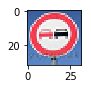

1.00 percent probabilty of :No entry
0.00 percent probabilty of :No passing
0.00 percent probabilty of :Stop
0.00 percent probabilty of :Speed limit (70km/h)
0.00 percent probabilty of :Priority road
--------------------------


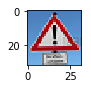

1.00 percent probabilty of :General caution
0.00 percent probabilty of :Bicycles crossing
0.00 percent probabilty of :Priority road
0.00 percent probabilty of :Traffic signals
0.00 percent probabilty of :Speed limit (30km/h)
--------------------------


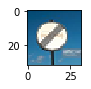

0.92 percent probabilty of :No vehicles
0.08 percent probabilty of :Priority road
0.00 percent probabilty of :No passing
0.00 percent probabilty of :End of all speed and passing limits
0.00 percent probabilty of :General caution
--------------------------


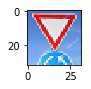

1.00 percent probabilty of :Yield
0.00 percent probabilty of :Speed limit (50km/h)
0.00 percent probabilty of :Double curve
0.00 percent probabilty of :Right-of-way at the next intersection
0.00 percent probabilty of :Priority road
--------------------------


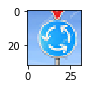

1.00 percent probabilty of :Roundabout mandatory
0.00 percent probabilty of :Right-of-way at the next intersection
0.00 percent probabilty of :Priority road
0.00 percent probabilty of :Vehicles over 3.5 metric tons prohibited
0.00 percent probabilty of :Speed limit (30km/h)
--------------------------


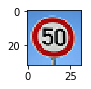

1.00 percent probabilty of :Speed limit (50km/h)
0.00 percent probabilty of :Speed limit (30km/h)
0.00 percent probabilty of :Speed limit (80km/h)
0.00 percent probabilty of :Roundabout mandatory
0.00 percent probabilty of :Speed limit (20km/h)
--------------------------


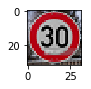

1.00 percent probabilty of :Speed limit (30km/h)
0.00 percent probabilty of :End of speed limit (80km/h)
0.00 percent probabilty of :Speed limit (50km/h)
0.00 percent probabilty of :Speed limit (80km/h)
0.00 percent probabilty of :Speed limit (20km/h)
--------------------------


In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    top_5_probs_arr, top_5_indices_arr = top_5_probs(X_c_prep, y_c)


for probs, class_indices, image in zip(top_5_probs_arr, top_5_indices_arr, X_c):
    plt.figure(figsize=(1,1))
    img = image.squeeze()
    plt.imshow(img)
    plt.show()

    for prob, class_indice in zip(probs, class_indices):
        print("%0.2f percent probabilty of :%s" % (prob, signnames[class_indice]))
    
    print("--------------------------")


> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 